# Deep Colorization

## Overview

This notebook creates a model that is able to colorize images to a certain extent, which combines a Fast deep Convolutional Neural Network trained from scratch with high-level features extracted from the MobileNet pre-trained model. This encoder-decoder model can process images of any size and aspect ratio. The training of this model is done on 60K images of MS-COCO dataset. How this model performs in coloring images are also showing in result section.

This notebook's work is inspired from https://github.com/titu1994/keras-mobile-colorizer which is also transfer to ipynb notebook too [[link]()].

## Introduction

There is something uniquely and powerfully satisfying about the simple act of adding color to black and white imagery. Moreover this coloring of gray-scale images can have a big impact in a wide variety of domains, for instance, re-master of historical images, dormant memories or expressing artistic creativity and improvement of surveillance feeds.

The information content of a gray-scale image is rather limited, thus adding the color components can provide more insights about its semantics. In the context of deep learning, models such as Inception [[ref]()], VGG [[ref]()] and others are usually trained using colored image datasets. When applying these networks on grayscale images, a prior colorization step can help improve the results. However, designing and implementing an effective and reliable system that automates this process still remains nowadays as a challenging task.

In this regard, below is the proposed model that is able to colorize images to a certain extent, combining a DCNN [[ref]()] architecture which utilizes a U-Net inspired model conditioned on MobileNet class features to generate a mapping from Grayscale to Color image. This work is based on the https://github.com/titu1994/keras-mobile-colorizer and https://github.com/baldassarreFe/deep-koalarization [[research paper](https://arxiv.org/pdf/1712.03400.pdf)].

### My contribution are as follows: 
  
1. Using fast algorithms for CNNs based on the minimal filtering algorithms pioneered by Winograd [[research paper](https://arxiv.org/abs/1509.09308)]
2. Analysis and intuition behind a colorization architecture based on CNNs.

## Background
Below are the few components that are used in the architecture of this model. Basic introduction of these components are given and more information you see the links provided in each section.


### U-Net: Convolutional Networks

The U-Net architecture is illustrated in below shown figure. It consists of a contracting path (left side) and an expansive path (right side). The architecture is that in the upsampling part, it has a large number of feature channels, which allow the network to propagate context information to higher resolution layers. As a consequence,
the expansive path is more or less symmetric to the contracting path, and yields a u-shaped architecture.

The contracting path follows the typical architecture of a convolutional network. It consists of the repeated application of two convolutions mostly 3x3 (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a max pooling mostly 2x2 operation with stride 2 for downsampling. At each downsampling step we double the number of feature channels. Every step in the expansive path consists of an upsampling of the feature map followed by a convolution mostly 2x2 (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two convolutions mostly 2x2 , each followed by a ReLU. The cropping is necessary due to the loss of border pixels in every convolution. At the final layer a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. In total the below network has 23 convolutional layers.


![U-Net Architecture](https://raw.githubusercontent.com/krypten/MobileDeepColorization/master/docs/images/u_net_architecture.png)



### MobileNet  
  
MobileNets are an efficent class of convolutional neural network. The main difference between the MobileNet architecture and a “traditional” CNN’s is instead of a single 3x3 convolution layer followed by batch norm and ReLU, MobileNets split the convolution into a 3x3 depthwise convolution and a 1×1 convolution called a pointwise convolution.


MobileNets introduce two simple global hyperparameters that efficiently trade off between latency and
accuracy : width multiplier and resolution multiplier. These hyper-parameters allow the model builder to choose the right sized model for their application based on the constraints of the problem. The width multiplier allows us to thin the network, while the resolution multiplier changes the input dimensions of the image, reducing the internal representation at every layer.

To learn more about how MobileNets work, read the [research paper](https://arxiv.org/pdf/1704.04861.pdf).

![MobileNet convolution](https://raw.githubusercontent.com/krypten/MobileDeepColorization/master/docs/images/mobilenet_architecture.png)

---

## Data
The data is from a dataset that is composed of thousands of pictures within a wide variety of sets. The dataset used for training, validation and testing is MS-COCO dataset 2014. The number of images are restricted to 60K images instead of all. 

For training on this dataset, storing the images and the embedding as separate files on disk (jpeg/png and csv for instance) would impact the performances during training, so all the image-embedding pairs are stored in binary format in large continuous [TFRecord](https://www.tensorflow.org/programmers_guide/datasets#consuming_tfrecord_data).

Also extracting the embeddings in real time during training could potentially slow down the process, so the MobileNet embeddings are computed in advance, stored together with the images and fed directly to the fusion layer.


### Colorspace
As part of preprocessing, the RGB layers of images are converted to Lab colorspaces. In Lab, 
we have an 'L' layer (Lightness) which represents the grayscale image, an 'a' layer that represents the red-green color spectrum, and a layer that represents the blue-yellow color spectrum. [[wiki](https://en.wikipedia.org/wiki/CIELAB_color_space)]. The 'L' layer ranges in value from 0-100, whereas the 'a' and 'b' layers are pixel values that range from 0-255. 

The 'L' layer acts  as input to the model. The 'a' and 'b' layers become the target.


## Architecture 
This model owes its architecture to [[1]](https://https://arxiv.org/pdf/1712.03400.pdf): given the luminance component of an image, the model estimates its a*b* components and combines them with the input to obtain the final estimate of the colored image. Instead of training a feature extraction branch from scratch, it makes use of a MobileNet network and retrieve an embedding of the gray-scale image from its last layer. The network architecture we used is illustrated in below figure.


![Deep Colorization Architecture](https://raw.githubusercontent.com/krypten/MobileDeepColorization/master/docs/images/deep_colorization_architecture.png)

## Experimentation

#### Install required modules
There are some few installations to run the program.

In [0]:
%%capture --no-display

# Install pip packages in the current Jupyter kernel
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install hazm
!{sys.executable} -m pip install keras
!{sys.executable} -m pip install pydot
!{sys.executable} -m pip install requests
!{sys.executable} -m pip install scikit-image
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install tqdm
!{sys.executable} -m pip install wget

#### Import required modules and configurations
The modules and configurations need be imported and initialized to move forward with the program.

In [2]:
## Import required modules
import glob

import keras

from keras.layers import Conv2D, Input, Reshape, RepeatVector, concatenate, UpSampling2D, Flatten, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.losses import mean_squared_error
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import tensorflow as tf
import wget


# Fetch the util file and import it
if os.path.exists('utils.py'):
  os.remove('utils.py')
  print('Removed the old copy of utils.py')
wget.download("https://raw.githubusercontent.com/krypten/MobileDeepColorization/master/utils.py")

import utils
from utils import TensorBoardBatch

# Configure tf to allocate memory as-needed
utils.configure_tensorflow()

sess = tf.Session()
K.set_session(sess)

Using TensorFlow backend.


TensorFlow Version: 1.9.0-rc1
Default GPU Device: /device:GPU:0


#### Constants
Declaring the global constants below to be used in notebook.

In [0]:
# Constants
TRAINING_TF_FILE_ID = "1DtW-secVk2-QdL1vUGgEPc3iL8T9CEnF"
TRAINING_DATASET_URL = "http://images.cocodataset.org/zips/train2014.zip"
TRAINING_TFRECORDS_PATH = "data/images.tfrecord"  # local path to tf record directory

VALIDATION_TF_FILE_ID = "1Gf6qtUGkk_yYiMffn1a1_8GzxJcQjv6k"
VALIDATION_DATASET_URL = "http://images.cocodataset.org/zips/val2014.zip"
VALIDATION_TFRECORDS_PATH = "data/val_images.tfrecord"  # local path to tf record directory

TEST_DATASET_URL = "http://images.cocodataset.org/zips/test2014.zip"

WEIGHTS_FILE_NAME = 'weights/mobilenet_model_improved.h5' # 'weights/mobilenet_model_original.h5'

IMAGE_SIZE = 128  # Global constant image size
EMBEDDING_IMAGE_SIZE = 224  # Global constant embedding size

### Hyperparameters

In [0]:
### Hyperparameters
batch_size = 100
epochs = 10
learning_rate=1e-3
nb_train_images = 60000 # there are 82783 images in MS-COCO, set this to how many samples you want to train on.

#### Get the Data
Run the following cell to download either the preprocessed dataset or dataset which is then converted to TFRecords.

In [5]:
# Save the train tf record file
utils.save_data_tfrecord(TRAINING_TFRECORDS_PATH, TRAINING_DATASET_URL, TRAINING_TF_FILE_ID)
print("{} has size {} MB".format(TRAINING_TFRECORDS_PATH, os.stat(TRAINING_TFRECORDS_PATH).st_size / 1024 / 1024))

# Save the validation tf record file
utils.save_data_tfrecord(VALIDATION_TFRECORDS_PATH, VALIDATION_DATASET_URL, VALIDATION_TF_FILE_ID)
print("{} has size {} MB".format(VALIDATION_TFRECORDS_PATH, os.stat(VALIDATION_TFRECORDS_PATH).st_size / 1024 / 1024))

data/images.tfrecord has size 14381.601808547974 MB
data/val_images.tfrecord has size 7040.7601499557495 MB



## Loss functions 
There is a combination of losses explained below used while training the model instead of plain ***'pixel-wise MSE'*** as done by major paper. The inspiration to combine various losses is from this [research paper](https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16.pdf) and [Image Super Resolution](https://arxiv.org/pdf/1612.07919.pdf) research paper where the see how using different combinations can effect the predicted image visual quality.

#### Pixel-wise loss 
Loss is the mean squared of the difference between each pixel of true image and predicted image.
$$ L_{e} = \frac{1}{H * W} \sum(I_{true} - I_{pred})^2 $$

#### Perceptual loss
Loss is the mean squared of the difference between gram matrix of the true image and predicted image.

$$ L_{p} = \frac{1}{weight} \sum(\phi_{I_{true}} - \phi_{I_{pred}})^2 $$

where the gram matrix is denoted by greek letter \phi which is calculated by flattening the image matrix.


### Metrics and Loss function

Functions related to measuring performance and losses are declared below.

In [0]:
mse_weight = 1.0 #1e-3

# set these to zeros to prevent learning
perceptual_weight = 1. / (2. * 128. * 128.) # scaling factor
attention_weight = 1.0 # 1.0

def gram_matrix(x):
    assert K.ndim(x) == 4

    with K.name_scope('gram_matrix'):
        if K.image_data_format() == "channels_first":
            batch, channels, width, height = K.int_shape(x)
            features = K.batch_flatten(x)
        else:
            batch, width, height, channels = K.int_shape(x)
            features = K.batch_flatten(K.permute_dimensions(x, (0, 3, 1, 2)))

        gram = K.dot(features, K.transpose(features)) # / (channels * width * height)
    return gram


def l2_norm(x):
    return K.sqrt(K.sum(K.square(x)))


def attention_vector(x):
    if K.image_data_format() == "channels_first":
        batch, channels, width, height = K.int_shape(x)
        filters = K.batch_flatten(K.permute_dimensions(x, (1, 0, 2, 3)))  # (channels, batch*width*height)
    else:
        batch, width, height, channels = K.int_shape(x)
        filters = K.batch_flatten(K.permute_dimensions(x, (3, 0, 1, 2)))  # (channels, batch*width*height)

    filters = K.mean(K.square(filters), axis=0)  # (batch*width*height,)
    filters = filters / l2_norm(filters)  # (batch*width*height,)
    return filters


def total_loss(y_true, y_pred):
    mse_loss = mse_weight * mean_squared_error(y_true, y_pred)
    perceptual_loss = perceptual_weight * K.sum(K.square(gram_matrix(y_true) - gram_matrix(y_pred)))
    attention_loss = attention_weight * l2_norm(attention_vector(y_true) - attention_vector(y_pred))

    return mse_loss + perceptual_loss + attention_loss

In [0]:
# shows the minimum value of the AB channels
def y_true_min(yt, yp):
    return K.min(yt)


# shows the maximum value of the RGB AB channels
def y_true_max(yt, yp):
    return K.max(yt)


# shows the minimum value of the predicted AB channels
def y_pred_min(yt, yp):
    return K.min(yp)


# shows the maximum value of the predicted AB channels
def y_pred_max(yt, yp):
    return K.max(yp)

### Model
Below the model code, its divived into 4 main components : The encoding and the feature extraction components obtain mid and high-level features, re- spectively, which are then merged in the fusion layer. Finally, the decoder uses these features to estimate the output.

#### Encoder
The Encoder processes H × W gray-scale images and outputs a H/8 × W/8 × 512 feature representation. To this end, it uses 8 convolutional layers with (3 × 1) and (1 x 3) kernels. Padding is used to preserve the layer’s input size. Furthermore, the few layers apply a stride of 2, consequentially halving the dimension of their output and hence reducing the number of computations required.

In [0]:
def build_encoder(image_size, learning_rate):
    encoder_input = Input(shape=(image_size, image_size, 1,))
    encoder1 = Conv2D(64, (3, 1), padding='same', activation='relu')(encoder_input)
    encoder1 = Conv2D(64, (1, 3), padding='same', activation='relu', strides=(2, 2))(encoder1)
    encoder = Conv2D(128, (3, 1), padding='same', activation='relu')(encoder1)
    encoder = Conv2D(128, (1, 3), padding='same', activation='relu')(encoder)
    encoder2 = Conv2D(128, (3, 1), padding='same', activation='relu')(encoder)
    encoder2 = Conv2D(128, (1, 3), padding='same', activation='relu', strides=(2, 2))(encoder2)
    encoder = Conv2D(256, (3, 1), padding='same', activation='relu')(encoder2)
    encoder = Conv2D(256, (1, 3), padding='same', activation='relu')(encoder)
    encoder = Conv2D(256, (3, 1), padding='same', activation='relu')(encoder)
    encoder = Conv2D(256, (1, 3), padding='same', activation='relu', strides=(2, 2))(encoder)
    encoder = Conv2D(512, (3, 1), padding='same', activation='relu')(encoder)
    encoder = Conv2D(512, (1, 3), padding='same', activation='relu')(encoder)
    encoder = Conv2D(512, (3, 1), padding='same', activation='relu')(encoder)
    encoder = Conv2D(512, (1, 3), padding='same', activation='relu')(encoder)
    encoder = Conv2D(256, (3, 1), padding='same', activation='relu')(encoder)
    encoder = Conv2D(256, (1, 3), padding='same', activation='relu')(encoder)

    return encoder, encoder1, encoder2, encoder_input

#### Fusion
The fusion layer takes the feature vector from MobileNet, replicates it H X W / 8^2 times and attaches it to the feature volume outputted by the encoder along the depth axis. This method is illustrated in figure in Architecture section. 3. This approach obtains a single volume with the encoded image and the mid-level features of shape H/8 × H/8 × 1257. By mirroring the feature vector and concatenating it several times we ensure that the semantic information conveyed by the feature vector is uniformly distributed among all spatial regions of the image. Moreover, this solution is also robust to arbitrary input image sizes, increasing the model flexibility. Finally, there are 256 convolutional kernels of size 1×1 applied, ultimately generating a feature volume of dimension H/8 × W/8 × 256.

In [0]:
def build_fusion_layer(encoder):
    batch, height, width, channels = K.int_shape(encoder)

    mobilenet_features_ip = Input(shape=(1000,))
    fusion = RepeatVector(height * width)(mobilenet_features_ip)
    fusion = Reshape((height, width, 1000))(fusion)
    fusion = concatenate([encoder, fusion], axis=-1)
    fusion = Conv2D(256, (1, 1), padding='same', activation='relu')(encoder)
    
    return fusion, mobilenet_features_ip

#### Decoder
Finally, the decoder takes this H/8 × W/8 × 256 volume and applies a series of convolutional and up-sampling layers in order to obtain a final layer with dimension H × W × 2. Up-sampling is performed using basic nearest neighbor approach so that the output’s height and width are twice the input’s.

In [0]:
def build_decoder(fusion, encoder1, encoder2):
    decoder = Conv2D(128, (3, 1), padding='same', activation='relu')(fusion)
    decoder = Conv2D(128, (1, 3), padding='same', activation='relu')(decoder)
    decoder = UpSampling2D()(decoder)
    decoder = concatenate([decoder, encoder2], axis=-1)
    decoder = Conv2D(64, (3, 1), padding='same', activation='relu')(decoder)
    decoder = Conv2D(64, (1, 3), padding='same', activation='relu')(decoder)
    decoder = Conv2D(64, (3, 1), padding='same', activation='relu')(decoder)
    decoder = Conv2D(64, (1, 3), padding='same', activation='relu')(decoder)
    decoder = UpSampling2D()(decoder)
    decoder = concatenate([decoder, encoder1], axis=-1)
    decoder = Conv2D(32, (3, 1), padding='same', activation='relu')(decoder)
    decoder = Conv2D(32, (1, 3), padding='same', activation='relu')(decoder)
    #decoder = Conv2DTranspose(2, (4, 4), strides=(2, 2), padding='same', activation='tanh')(decoder)
    decoder = Conv2D(2, (3, 1), padding='same', activation='tanh')(decoder)
    decoder = Conv2D(2, (1, 3), padding='same', activation='tanh')(decoder)
    decoder = UpSampling2D((2, 2))(decoder)

    return decoder

#### Build Model
Add all the components together to build the colorization model for colorizing gray-scaled images.

In [0]:
def build_model(image_size, learning_rate=1e-3):
    '''
    Creates a Colorizer model. Note the difference from the report
    - https://github.com/baldassarreFe/deep-koalarization/blob/master/report.pdf
    I use a long skip connection network to speed up convergence and
    boost the output quality.
    '''
    ## Encoder Model
    [encoder, encoder1, encoder2, encoder_input] = build_encoder(image_size, learning_rate)
    ## Input Fusion
    [fusion, mobilenet_features_ip] = build_fusion_layer(encoder)
    ## Decoder Model
    decoder = build_decoder(fusion, encoder1, encoder2)

    # Creates a Colorizer model
    model = Model([encoder_input, mobilenet_features_ip], decoder, name='Colorizer')
    model.compile(optimizer=Adam(learning_rate), loss='mse', metrics=[y_true_max,
                                                                y_true_min,
                                                                y_pred_max,
                                                                y_pred_min])

    print("Model built and compiled")
    return model

In [12]:
# Model Summary
model = build_model(IMAGE_SIZE, learning_rate)
model.summary()

Model built and compiled
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 256         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 64)   12352       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 64, 64, 128)  24704       conv2d_2[0][0]                   
____________________________________________________________________________________

## Training
Finally, to begin the training process, it fits the model with training variables, inform Keras about how many images to look at simultaneously (steps per epochs = nb_train_images // batch_size), how long to train the model (epoch=10) and to provide us with a training log (verbose = 1). It uses [Adam](https://keras.io/optimizers/#adam) gradient descent optimization function.

In [13]:
# Continue training if weights are available
if not os.path.exists('weights/'):
    os.makedirs('weights/')

if not os.path.exists(WEIGHTS_FILE_NAME):
    wget.download("https://github.com/krypten/MobileDeepColorization/raw/master/weights/mobilenet_model_improved.h5", out=WEIGHTS_FILE_NAME)
model.load_weights(WEIGHTS_FILE_NAME)

# Use Batchwise TensorBoard callback
tensor_board = TensorBoardBatch(batch_size=batch_size)
checkpoint = ModelCheckpoint(WEIGHTS_FILE_NAME, monitor='loss', verbose=1, save_best_only=True, save_weights_only=True)
callbacks_list = [checkpoint, tensor_board]

# Training model
model.fit_generator(generator=utils.train_generator(TRAINING_TFRECORDS_PATH, batch_size, IMAGE_SIZE),
                    steps_per_epoch=nb_train_images // batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks_list,
                    validation_data=utils.val_batch_generator(VALIDATION_TFRECORDS_PATH, batch_size, IMAGE_SIZE),
                    validation_steps=1
                   )

Epoch 1/10
600/600 [==============================] - 667s 1s/step - loss: 0.0129 - y_true_max: 0.7168 - y_true_min: -0.7001 - y_pred_max: 0.1676 - y_pred_min: -0.0960 - val_loss: 0.0109 - val_y_true_max: 0.7284 - val_y_true_min: -0.6102 - val_y_pred_max: 0.1746 - val_y_pred_min: -0.1570

Epoch 00001: loss improved from inf to 0.01292, saving model to weights/mobilenet_model_improved.h5
Epoch 2/10
  1/600 [..............................] - ETA: 10:59 - loss: 0.0120 - y_true_max: 0.7390 - y_true_min: -0.7629 - y_pred_max: 0.1637 - y_pred_min: -0.1624

600/600 [==============================] - 654s 1s/step - loss: 0.0122 - y_true_max: 0.7175 - y_true_min: -0.6969 - y_pred_max: 0.1896 - y_pred_min: -0.1872 - val_loss: 0.0115 - val_y_true_max: 0.7180 - val_y_true_min: -0.7343 - val_y_pred_max: 0.1654 - val_y_pred_min: -0.1871

Epoch 00002: loss improved from 0.01292 to 0.01218, saving model to weights/mobilenet_model_improved.h5
Epoch 3/10
 14/600 [..............................] - ETA: 10:36 - loss: 0.0126 - y_true_max: 0.7118 - y_true_min: -0.7174 - y_pred_max: 0.1811 - y_pred_min: -0.1986

600/600 [==============================] - 653s 1s/step - loss: 0.0120 - y_true_max: 0.7176 - y_true_min: -0.6978 - y_pred_max: 0.2141 - y_pred_min: -0.2174 - val_loss: 0.0106 - val_y_true_max: 0.6800 - val_y_true_min: -0.6952 - val_y_pred_max: 0.2461 - val_y_pred_min: -0.3208

Epoch 00003: loss improved from 0.01218 to 0.01198, saving model to weights/mobilenet_model_improved.h5
Epoch 4/10
 17/600 [..............................] - ETA: 10:35 - loss: 0.0118 - y_true_max: 0.7172 - y_true_min: -0.6810 - y_pred_max: 0.2424 - y_pred_min: -0.2763

600/600 [==============================] - 654s 1s/step - loss: 0.0118 - y_true_max: 0.7174 - y_true_min: -0.6981 - y_pred_max: 0.2417 - y_pred_min: -0.2490 - val_loss: 0.0105 - val_y_true_max: 0.7242 - val_y_true_min: -0.7195 - val_y_pred_max: 0.2442 - val_y_pred_min: -0.2159

Epoch 00004: loss improved from 0.01198 to 0.01176, saving model to weights/mobilenet_model_improved.h5
Epoch 5/10
 18/600 [..............................] - ETA: 10:33 - loss: 0.0111 - y_true_max: 0.7145 - y_true_min: -0.7075 - y_pred_max: 0.2795 - y_pred_min: -0.2584

600/600 [==============================] - 654s 1s/step - loss: 0.0117 - y_true_max: 0.7176 - y_true_min: -0.6967 - y_pred_max: 0.2608 - y_pred_min: -0.2732 - val_loss: 0.0105 - val_y_true_max: 0.7161 - val_y_true_min: -0.6362 - val_y_pred_max: 0.2833 - val_y_pred_min: -0.2513

Epoch 00005: loss improved from 0.01176 to 0.01165, saving model to weights/mobilenet_model_improved.h5
Epoch 6/10
 18/600 [..............................] - ETA: 10:33 - loss: 0.0116 - y_true_max: 0.7236 - y_true_min: -0.7011 - y_pred_max: 0.2588 - y_pred_min: -0.2825

600/600 [==============================] - 654s 1s/step - loss: 0.0116 - y_true_max: 0.7182 - y_true_min: -0.6991 - y_pred_max: 0.2700 - y_pred_min: -0.2818 - val_loss: 0.0114 - val_y_true_max: 0.7406 - val_y_true_min: -0.6725 - val_y_pred_max: 0.2631 - val_y_pred_min: -0.1756

Epoch 00006: loss improved from 0.01165 to 0.01160, saving model to weights/mobilenet_model_improved.h5
Epoch 7/10
 18/600 [..............................] - ETA: 10:33 - loss: 0.0118 - y_true_max: 0.7150 - y_true_min: -0.6880 - y_pred_max: 0.2360 - y_pred_min: -0.2577

600/600 [==============================] - 654s 1s/step - loss: 0.0115 - y_true_max: 0.7173 - y_true_min: -0.6983 - y_pred_max: 0.2760 - y_pred_min: -0.2816 - val_loss: 0.0106 - val_y_true_max: 0.7048 - val_y_true_min: -0.6732 - val_y_pred_max: 0.2631 - val_y_pred_min: -0.2681

Epoch 00007: loss improved from 0.01160 to 0.01153, saving model to weights/mobilenet_model_improved.h5
Epoch 8/10
 18/600 [..............................] - ETA: 10:31 - loss: 0.0119 - y_true_max: 0.7111 - y_true_min: -0.6788 - y_pred_max: 0.2920 - y_pred_min: -0.2836

600/600 [==============================] - 654s 1s/step - loss: 0.0115 - y_true_max: 0.7167 - y_true_min: -0.7008 - y_pred_max: 0.2904 - y_pred_min: -0.2876 - val_loss: 0.0099 - val_y_true_max: 0.6967 - val_y_true_min: -0.8229 - val_y_pred_max: 0.2659 - val_y_pred_min: -0.2544

Epoch 00008: loss improved from 0.01153 to 0.01145, saving model to weights/mobilenet_model_improved.h5
Epoch 9/10
 18/600 [..............................] - ETA: 10:33 - loss: 0.0112 - y_true_max: 0.7149 - y_true_min: -0.7056 - y_pred_max: 0.2928 - y_pred_min: -0.2753

600/600 [==============================] - 654s 1s/step - loss: 0.0114 - y_true_max: 0.7168 - y_true_min: -0.6983 - y_pred_max: 0.3022 - y_pred_min: -0.2909 - val_loss: 0.0105 - val_y_true_max: 0.7077 - val_y_true_min: -0.6616 - val_y_pred_max: 0.3857 - val_y_pred_min: -0.2875

Epoch 00009: loss improved from 0.01145 to 0.01139, saving model to weights/mobilenet_model_improved.h5
Epoch 10/10
 18/600 [..............................] - ETA: 10:32 - loss: 0.0112 - y_true_max: 0.7188 - y_true_min: -0.7145 - y_pred_max: 0.2862 - y_pred_min: -0.2962

600/600 [==============================] - 654s 1s/step - loss: 0.0114 - y_true_max: 0.7174 - y_true_min: -0.6983 - y_pred_max: 0.3085 - y_pred_min: -0.2905 - val_loss: 0.0110 - val_y_true_max: 0.7105 - val_y_true_min: -0.6268 - val_y_pred_max: 0.3168 - val_y_pred_min: -0.3092

Epoch 00010: loss improved from 0.01139 to 0.01137, saving model to weights/mobilenet_model_improved.h5


Exception ignored in: <generator object val_batch_generator at 0x7f01cc8b7a98>
Traceback (most recent call last):
  File "/content/utils.py", line 336, in val_batch_generator
    yield ([l, features], ab)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1599, in __exit__
    self._default_graph_context_manager.__exit__(exec_type, exec_value, exec_tb)
  File "/usr/lib/python3.6/contextlib.py", line 99, in __exit__
    self.gen.throw(type, value, traceback)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 5287, in get_controller
    context.context().context_switches.pop()
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/context.py", line 136, in pop
    self.stack.pop()
IndexError: pop from empty list
Exception ignored in: <generator object train_generator at 0x7f01cc8b79e8>
Traceback (most recent call last):
  File "/content/utils.py", line 310, in train_generator
    yield ([l, featu

In [0]:
# Dowload weights
from google.colab import files
files.download(WEIGHTS_FILE_NAME)

## Evaluation
Test the model against the test dataset.

In [15]:
batch_size = 10
image_size = 128

# Load the best weights
model = build_model(IMAGE_SIZE, learning_rate)
model.load_weights(WEIGHTS_FILE_NAME)

# Test the model
test_data = utils.load_test_data(TEST_DATASET_URL, image_size, 100)
x_lab, x_features = utils.prepare_input_image_batch(test_data, EMBEDDING_IMAGE_SIZE, batch_size)

predictions = model.predict([x_lab, x_features], batch_size, verbose=1)
utils.postprocess_output(x_lab, predictions, image_size=image_size)

Model built and compiled


dataset/test2014: 6.66GB [00:49, 134MB/s]                            


Extracting content from Zip file
Extraction Complete


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Loaded 0.00 percentage of images from directory
Loaded 5.00 percentage of images from directory
Loaded 10.00 percentage of images from directory
Loaded 15.00 percentage of images from directory
Loaded 20.00 percentage of images from directory
Loaded 25.00 percentage of images from directory
Loaded 30.00 percentage of images from directory
Loaded 35.00 percentage of images from directory
Loaded 40.00 percentage of images from directory
Loaded 45.00 percentage of images from directory
Loaded 50.00 percentage of images from directory
Loaded 55.00 percentage of images from directory
Loaded 60.00 percentage of images from directory
Loaded 65.00 percentage of images from directory
Loaded 70.00 percentage of images from directory
Loaded 75.00 percentage of images from directory
Loaded 80.00 percentage of images from directory
Loaded 85.00 percentage of images from directory
Loaded 90.00 percentage of images from directory
Loaded 95.00 percentage of images from directory
Images loaded. Shape =

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Finished processing 10.00 percentage of images
Finished processing 15.00 percentage of images
Finished processing 20.00 percentage of images
Finished processing 25.00 percentage of images
Finished processing 30.00 percentage of images
Finished processing 35.00 percentage of images
Finished processing 40.00 percentage of images
Finished processing 45.00 percentage of images
Finished processing 50.00 percentage of images
Finished processing 55.00 percentage of images
Finished processing 60.00 percentage of images
Finished processing 65.00 percentage of images
Finished processing 70.00 percentage of images
Finished processing 75.00 percentage of images
Finished processing 80.00 percentage of images
Finished processing 85.00 percentage of images
Finished processing 90.00 percentage of images
Finished processing 95.00 percentage of images


## Results 
Display the colorizer model predicted image along with the original image and the gray scale image. 

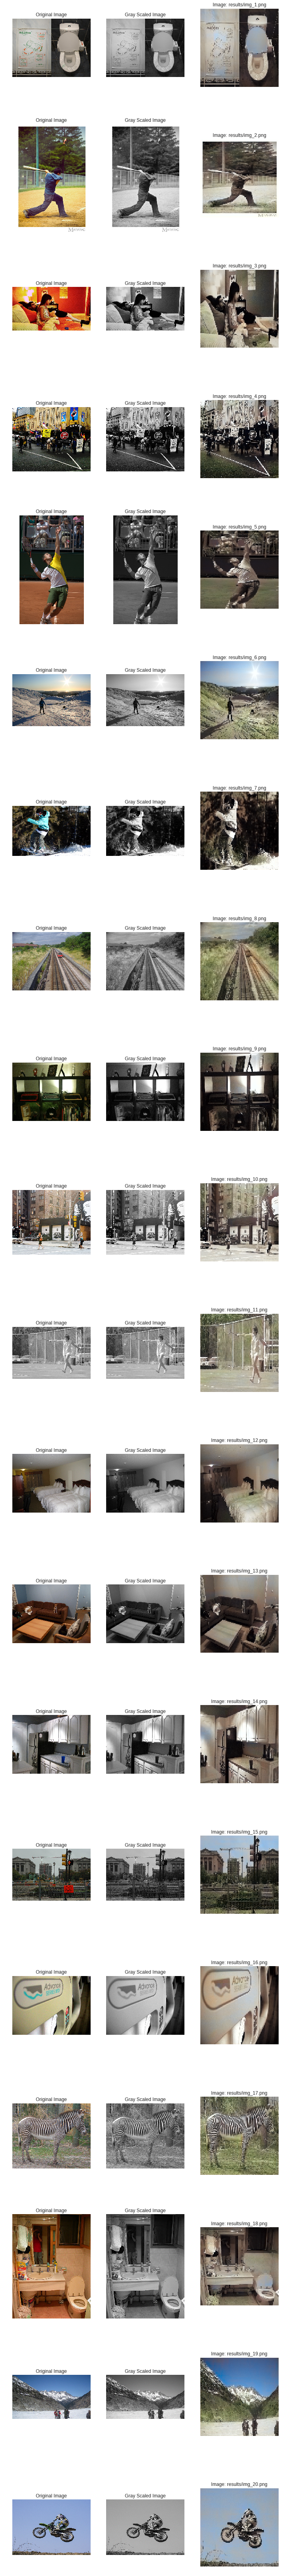

In [16]:
import re
from skimage.color import rgb2gray, gray2rgb

# Show images for test data
files = glob.glob("results/*.png")
org_files = glob.glob("dataset/test2014/*.jpg")

n_files = 20

def digit_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

files = digit_sort(files)[:n_files]
org_files = org_files[:n_files]

plt.figure(figsize=(12, 120))

for i, file_name in enumerate(files):
    # Original Image
    plt.subplot(n_files, 3, 3*i + 1)
    plt.axis('off')
    org_file_name = org_files[i]
    org_img = mpimg.imread(org_file_name)
    plt.title('Original Image')
    plt.imshow(org_img)
    # Gray Scaled Image
    plt.subplot(n_files, 3, 3*i + 2)
    plt.axis('off')
    org_img = mpimg.imread(org_file_name)
    plt.title('Gray Scaled Image')
    plt.imshow(gray2rgb(rgb2gray(org_img)))
    # Predicted Colored Image
    plt.subplot(n_files, 3, 3*i + 3)
    plt.axis('off')
    img = mpimg.imread(file_name)
    plt.title('Image: %s' % file_name)
    plt.imshow(img)


## Conclusions 
  
The colorizer model does pretty fine with colorizing gray scaled images. Nevertheless, the performance in coloring small details is still to be improved. As we only used a reduced subset of MS-COCO, only a small portion of the spectrum of possible subjects is represented, therefore, the performance on unseen images highly depends on their specific contents. To overcome this issue, our network should be trained over a larger training dataset.  

Otherwise, we need improve the model or come-up with a new approach.